In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st

In [179]:
games_df = pd.read_csv('games.csv')

In [177]:
# games_df.info()

In [180]:
# games_df.isna().sum()

In [181]:
# games_df.head(5)

Данные имеют некоторое количество пропусков в столбцах с именем пользователя, жанра, года релиза игры, а также в столбцах с оценкой игры пользователями и критиками. Пропуски в столбцах с именем и жанром можно удалить, так как их всего 2. Пропуски в столбцах с оценками я оставлю пока, так как корректно их заполнить невозможно, потому что оценка является личным мнением каждого пользователя или критика. Пропуски в столбце с датой релиза также оставлю, вероятнее всего, они появились там из-за ошибки выгрузки данных, всего у нас 269 пропусков и искать вручную информацию по каждой игре не лучшая идея.

ПОДГОТОВКА ДАННЫХ

In [182]:
games_df.rename(columns=str.lower, inplace=True)

In [183]:
games_df = games_df.dropna(subset=['name', 'genre', 'year_of_release'])

In [184]:
games_df['year_of_release'] = games_df['year_of_release'].astype(int)

In [185]:
tbd_df = games_df.query('user_score == "tbd"')
tbd_df.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E


In [189]:
# tbd_df.shape

In [190]:
games_df.loc[games_df['user_score'] == "tbd", 'user_score'] = np.nan

In [191]:
# games_df['user_score'].unique()

In [192]:
games_df['copy_sales'] = games_df['na_sales'] + games_df['jp_sales'] + games_df['eu_sales'] + games_df['other_sales']

In [194]:
# games_df.head(10)

In [195]:
# games_df.shape

Для удобства работы с данными названия были переведены в нижний регистр, также я удалила пропуски в столбцах с именем, жанром и годом релиза игры. Так как для анализа важны игры с годом выпуска, а корректно его заполнить не получится, пропуски были удалены. Также я изменила тип столбца с годом на целое число. Вероятно, пропущенные значения во всех столбцах кроме оценки критиков и пользователей были получены из-за некорректной выгрузки данных. Пропуски в столбце с оценкой критиков могли появиться там по той причине, что игры не оценивались. Столбец с пропусками пользовательском рейтинге я также не заполняла, потому что указать среднюю оценку будет неправильным решением, а пропущенные значения могли появиться там также из-за того, что игра еще не была оценена или возникла ошибка при сборе или выгрузке данных. 

TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. В нашем случае мы имеем 2376 таких значений, думаю, будет логично заполнить их значением NaN, чтобы в дальнейшем работать с ними как с пропусками.

ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ

Для начала посмотрим в какие годы было продано больше всего копий игр.

In [196]:
year_statistics = games_df.pivot_table(index='year_of_release', values='platform', aggfunc='count')
year_statistics.sort_values(by='platform', ascending=False)

,platform
year_of_release,
2008,1427
2009,1426
2010,1255
2007,1197
2011,1136
2006,1006
2005,939
2002,829
2003,775


Теперь можем узнать наиболее популярные игровые платформы среди пользователей.

In [197]:
platform_statistics = games_df.pivot_table(index='platform', values='copy_sales', aggfunc='sum')
platform_statistics.sort_values(by='copy_sales', ascending=False)

,copy_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Выберем из них топ-5, с которыми будем дальше работать.

In [198]:
top_5_platforms = platform_statistics.sort_values(by='copy_sales', ascending=False).head(5).index.get_level_values('platform')
top_5_platforms

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS'], dtype='object', name='platform')

Теперь мы можем отследиь как изменялись продажи среди 5 наиболее популярных игровых платформ.

In [199]:
top_5_data = games_df[games_df['platform'].isin(top_5_platforms)]

In [200]:
top_5 = top_5_data.query('year_of_release >= 2000')

In [201]:
top_5 = top_5.pivot_table(index=['platform', 'year_of_release'], values='copy_sales', aggfunc='sum').reset_index()
top_5

,platform,year_of_release,copy_sales
0,DS,2004,17.27
1,DS,2005,130.14
2,DS,2006,119.81
3,DS,2007,146.94
4,DS,2008,145.31
5,DS,2009,119.54
6,DS,2010,85.02
7,DS,2011,26.18
8,DS,2012,11.01
9,DS,2013,1.54


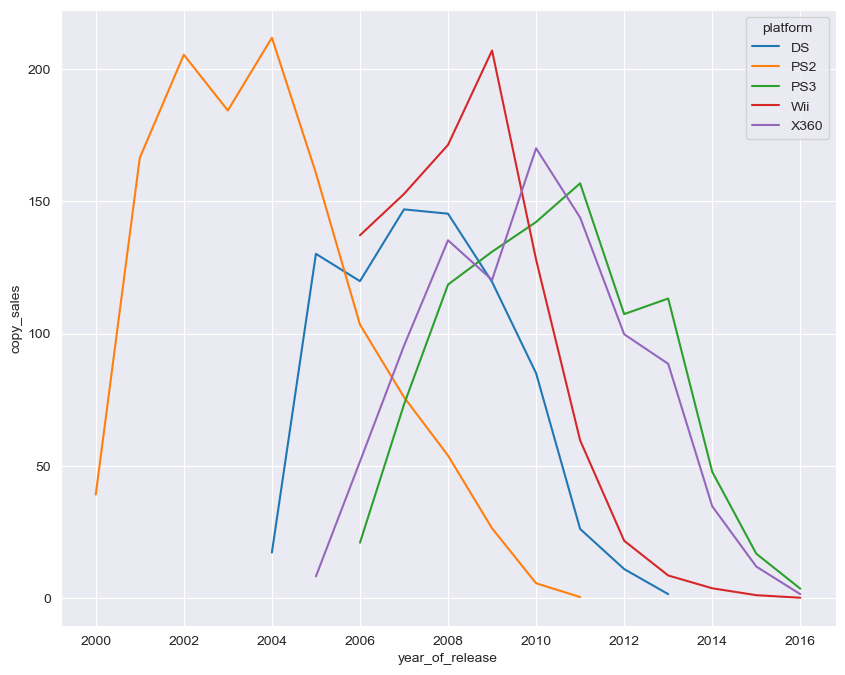

In [202]:
plt.figure(figsize=(10, 8))
sns.lineplot(data=top_5, x='year_of_release', y='copy_sales', hue='platform');

Я выбрала топ-5 игр начиная с 2000 года, так как до этого игры выпускались только на платформе DS. В дальнейшем анализе будут учитываться платформы только за последние 5 лет, так как некоторые из них только начали развиваться, а некоторые, наоборот, стали менее популярными и игры на них практически перестали выпускаться, как, например, PS2. Средняя продолжительность жизни платформы составляет 4-5 лет. На 4-5 году платформы приходят в упадок, так как на них начинает выпускаться все меньше и меньше игр. Исключением можно назвать PS3 и X360, которые продержались на рынке около 7 лет.

Так как средняя продолжительность жизни платформы около 4 лет, чтобы спрогнозировать данные на 2017, я возьму наиболее популярные платформы за последние 4 года. Также, если учесть, что игры в среднем разрабатываются около 4 лет, то игры, разработка которых была начата в 2013 выйдут в 2017 году

In [210]:
actual_platforms = games_df.query('year_of_release >= 2013').platform
actual_platforms.unique()

array(['PS3', 'X360', 'PS4', '3DS', 'XOne', 'WiiU', 'Wii', 'PC', 'PSV',
       'DS', 'PSP'], dtype=object)

In [204]:
top_actual = games_df[games_df['platform'].isin(actual_platforms)]

In [205]:
top_actual = top_actual.query('year_of_release >= 2013')

Также известно, что поддержка PSP была прекращена в 2015 году, а DS был заменен на 3DS, поэтому исключим их из прогноза.

In [217]:
top_9_actual = top_actual.pivot_table(index=['platform', 'year_of_release'], values='copy_sales', aggfunc='sum').reset_index()
top_9_actual = top_9_actual[(top_9_actual.platform != "PSP") &  (top_9_actual.platform != "DS")]
top_9_actual

,platform,year_of_release,copy_sales
0,3DS,2013,56.57
1,3DS,2014,43.76
2,3DS,2015,27.78
3,3DS,2016,15.14
5,PC,2013,12.38
6,PC,2014,13.28
7,PC,2015,8.52
8,PC,2016,5.25
9,PS3,2013,113.25
10,PS3,2014,47.76


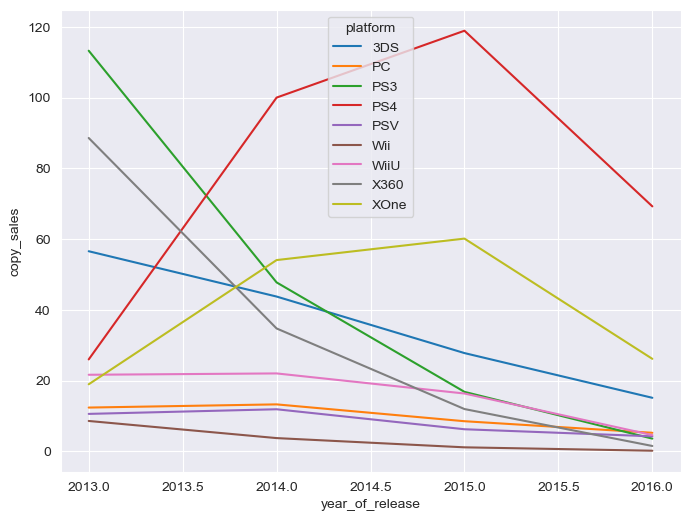

In [219]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=top_9_actual, x='year_of_release', y='copy_sales', hue='platform');